### ***DATA DESCRIPTION AND EXPLORATION***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
import scipy.stats

In [2]:
df = pd.read_excel("retail.xlsx", engine='openpyxl')

In [3]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

### Geographical Distribution

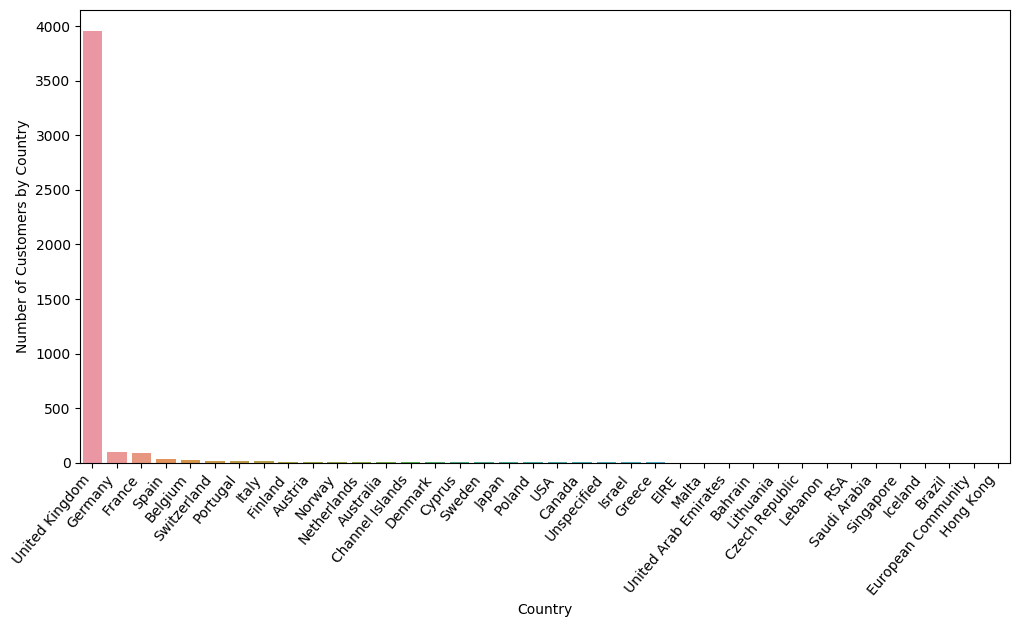

In [4]:
country_df = pd.DataFrame(df.groupby('Country')['CustomerID'].nunique())
country_df.columns = ['Number of Customers by Country']
country_df.sort_values('Number of Customers by Country', inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(12,6),dpi=100)
ax=sns.barplot(x=country_df.index, y=country_df['Number of Customers by Country'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

***Being a UK based company, most of its customer are from United Kingdom. This makes the dataset imbalanced in terms of geographical feature***

In [5]:
df_uk = df[df['Country']=='United Kingdom']
df_uk.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
print("Percentage of customers from the UK: ", round(df_uk['CustomerID'].nunique() * 100 / df['CustomerID'].nunique(),2),"%" )
print("Number of transactions in UK: ", df_uk['InvoiceNo'].nunique())
print("Number of products bought in UK: ", df_uk['StockCode'].nunique())
print("Number of customers in UK:", df_uk['CustomerID'].nunique())

Percentage of customers from the UK:  90.35 %
Number of transactions in UK:  23494
Number of products bought in UK:  4065
Number of customers in UK: 3950


In [7]:
df_uk = df[df['Country']!='United Kingdom']
print("Percentage of customers from Abroad: ", round(df_uk['CustomerID'].nunique() * 100 / df['CustomerID'].nunique(),2),"%" )
print("Number of transactions in Abroad: ", df_uk['InvoiceNo'].nunique())
print("Number of products Bought in Abroad: ", df_uk['StockCode'].nunique())
print("Number of customers in Abroad:", df_uk['CustomerID'].nunique())

Percentage of customers from Abroad:  9.65 %
Number of transactions in Abroad:  2406
Number of products Bought in Abroad:  2807
Number of customers in Abroad: 422


In [8]:
cancelled = df[df['InvoiceNo'].astype(str).str.contains('C')]
print("Number of cancelled transaction:", len(cancelled))

Number of cancelled transaction: 9288


### Order Distribution by Month

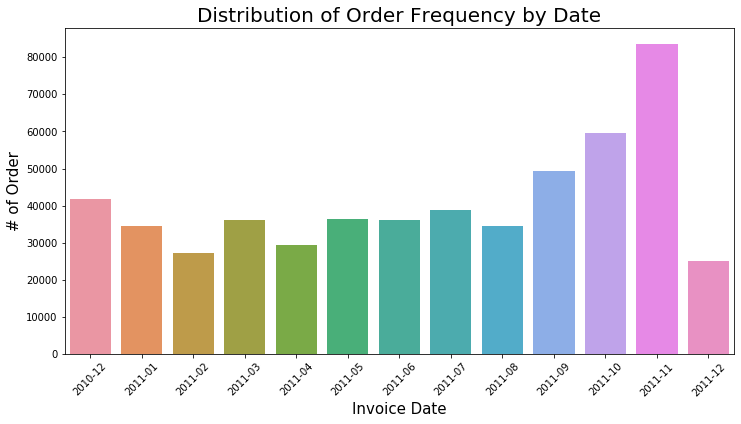

In [25]:
df['Year_Month'] = df['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))   
plt.figure(figsize=(12,6))
sns.countplot(x='Year_Month', data=df[~df['InvoiceNo'].astype('str').str.startswith(('C'))])
plt.title('Distribution of Order Frequency by Date', fontsize=20)
plt.xlabel('Invoice Date',fontsize=15)
plt.ylabel('# of Order',fontsize=15)
plt.xticks(rotation=45)
plt.show()


***Order placement at the end of the year increases due to the presence of different festivals. Moreover, as many of the customers are wholesale buyers, they stock their products during the festive seasons.***

In [31]:
customers_order = pd.DataFrame(df.groupby('CustomerID')['InvoiceNo'].nunique())
customers_order.describe()

,InvoiceNo
count,4372.000000
mean,5.075480
std,9.338754
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,248.000000


***Number of times an average customer orders is 5***

### Money spent by Customers

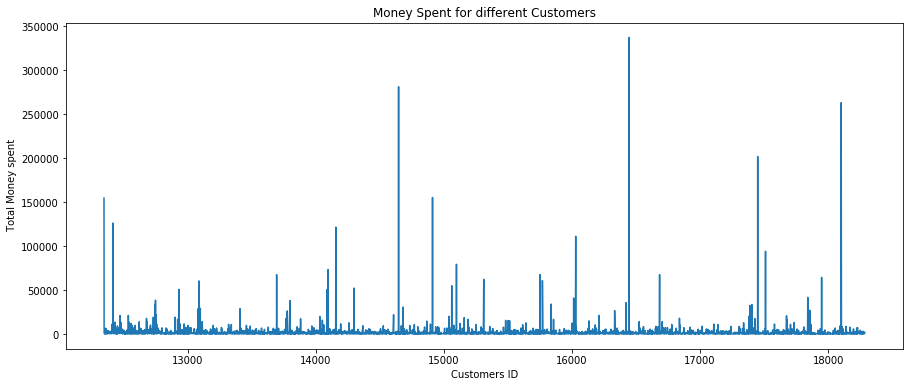

In [19]:
df['TotalPrice'] = df.Quantity*df.UnitPrice
df['TotalPrice'] = df['TotalPrice'].apply(lambda x: abs(x))
money_spent = df.groupby(by=['CustomerID'], as_index=False)['TotalPrice'].sum()
plt.subplots(figsize=(15,6))
plt.plot(money_spent.CustomerID, money_spent.TotalPrice)
plt.xlabel('Customers ID')
plt.ylabel(' Total Money spent')
plt.title('Money Spent for different Customers')
plt.show()


### Distribution of UnitPrice and Quantity

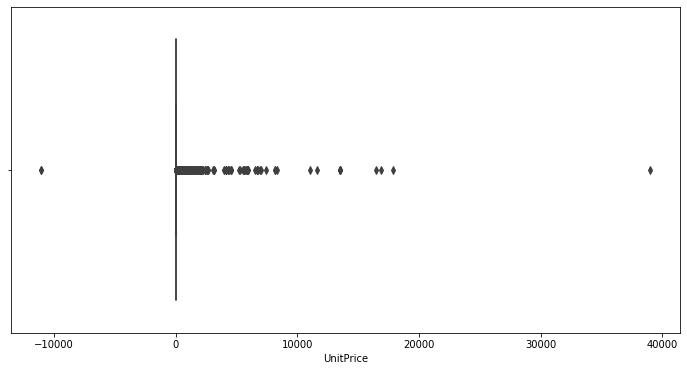

In [27]:
# check the distribution of unit price
plt.subplots(figsize=(12,6))
sns.boxplot(df.UnitPrice)
plt.show()


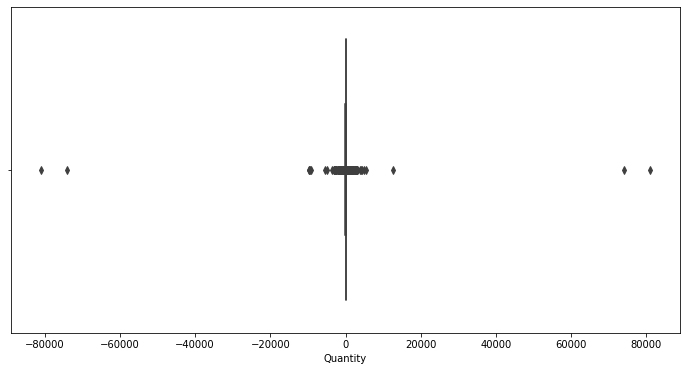

In [28]:
# check the distribution of unit price
plt.subplots(figsize=(12,6))
sns.boxplot(df.Quantity)
plt.show()


***So outliers are present in both these features and there is the presence of negative values in Quantity***

### Product Distribution

In [43]:
product_variety = pd.DataFrame(df.groupby('InvoiceNo')['StockCode'].nunique())
product_variety.columns=['productsNumber']

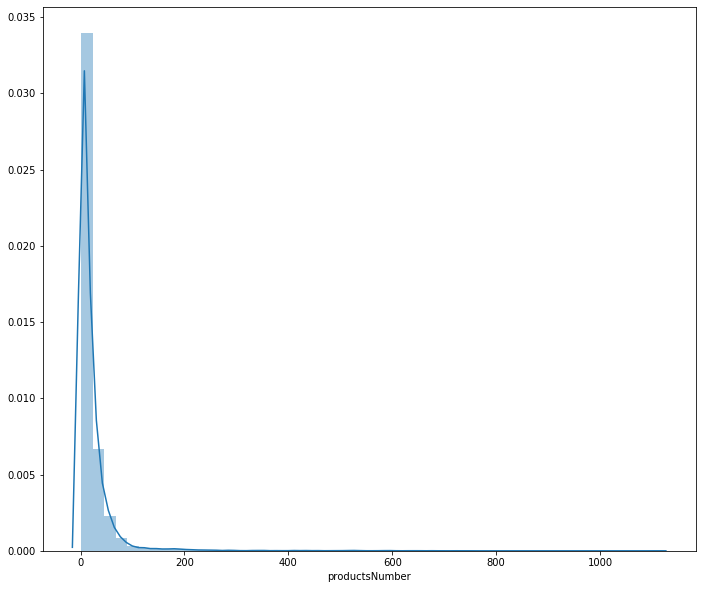

In [44]:
#Visualize the variable productsNumber distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 10)
sns.distplot(product_variety['productsNumber'],ax=ax)
plt.show()


In [45]:
product_variety.describe()

,productsNumber
count,25900.000000
mean,20.510618
std,42.500488
min,1.000000
25%,2.000000
50%,10.000000
75%,23.000000
max,1110.000000


***So the product variety per order has a skewed distribution***



***Rank among customers based on the number of products they bought in total***

In [48]:
temp = df.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
top_baskets = products_per_basket.sort_values('Number of products', ascending=False)
top_baskets.head(10)

,CustomerID,Number of products
4042,17841.0,7983
1895,14911.0,5903
1300,14096.0,5128
330,12748.0,4642
1674,14606.0,2782
2192,15311.0,2491
1703,14646.0,2085
568,13089.0,1857
698,13263.0,1677
1447,14298.0,1640


### Most popular StockCode

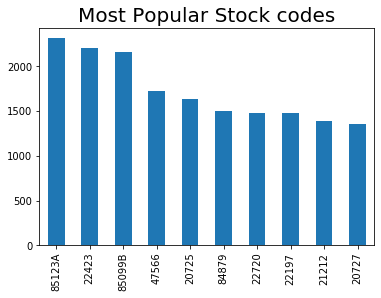

In [82]:
df['StockCode'].value_counts().head(10).plot.bar()
plt.title('Most Popular Stock codes', fontsize = 20)
plt.show()

In [77]:
df['day'] = df['InvoiceDate'].dt.day
df['month'] = df['InvoiceDate'].dt.month
df['year'] = df['InvoiceDate'].dt.year
df['month_year'] = pd.to_datetime(df[['year', 'month']].assign(Day=1))


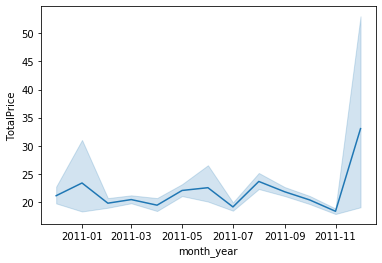

In [78]:
ax = sns.lineplot(x = 'month_year', y='TotalPrice', data = df)


***So, most of the revenue are also generated at the end of the year during the time of festival***

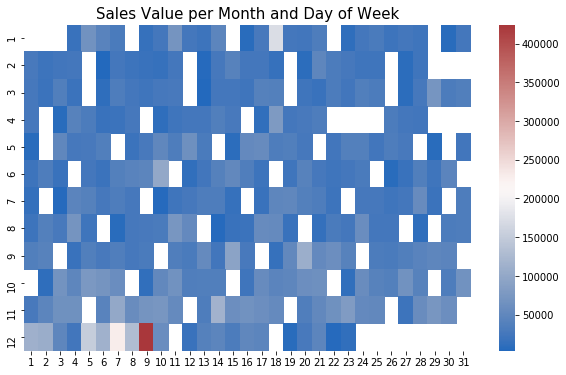

In [79]:
# HM_Data = df.pivot_table(index = 'month',columns = 'day', values = 'TotalPrice', aggfunc='sum')
# plt.figure(figsize = (10,6))
# sns.heatmap(HM_Data, cmap = 'vlag').set(xlabel='', ylabel='')
# plt.title('Sales Value per Month and Day of Week', fontsize = 15)
# plt.show()